In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
import scipy
#from numpy.linalg import svd

import warnings
warnings.filterwarnings("ignore")


In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), './'))
    
    from main import *
    import dNN
    import visualization as vis
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("data/LS_processed.h5ad")
ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'log1p', 'raw'

## create a Xct_metrics obj:

In [ ]:
skin = Xct_metrics(ada)
type(skin)

In [ ]:
skin.LRs.head()

In [ ]:
skin._genes_index_DB

In [ ]:
ada.var_names[1194-1] #check

In [ ]:
skin.chen2016_fit(ada, plot = True, verbose = True)

## create a Xct obj with GRN building:

In [4]:
obj1 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'full', verbose = True)

print(obj1)

init an Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)...
loading GRNs...
building correspondence...
init completed.
Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [5]:
df1 = obj1.fill_metric()
df1

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
18,IGF1,NTRK2,0.029522,0.024446,0.067410,0.027285,2.283343,1.116142,8.794479,6.757026,0.156436,-0.338065
28,AREG,NTRK2,0.003443,0.024446,0.005726,0.027285,1.663072,1.116142,21.977261,6.757026,-0.221117,-0.338065
33,FGF2,NTRK2,0.076530,0.024446,0.142827,0.027285,1.866276,1.116142,4.938230,6.757026,-0.075862,-0.338065
35,FGF7,NTRK2,0.449156,0.024446,0.835224,0.027285,1.859543,1.116142,2.034720,6.757026,0.023099,-0.338065
53,BDNF,NTRK2,0.009386,0.024446,0.016305,0.027285,1.737234,1.116142,13.604940,6.757026,-0.094830,-0.338065
...,...,...,...,...,...,...,...,...,...,...,...,...
7884,LAMB1,SV2B,0.192922,0.015761,0.356617,0.019873,1.848509,1.260899,3.095425,8.944272,-0.019347,-0.338065
7890,LAMC3,SV2B,0.343355,0.015761,0.610706,0.019873,1.778645,1.260899,2.276004,8.944272,-0.046932,-0.338065
7894,LAMB2,SV2B,1.027162,0.015761,1.343443,0.019873,1.307918,1.260899,1.128420,8.944272,-0.030466,-0.338065
8023,FSTL1,DIP2A,1.154967,0.066773,1.490066,0.086209,1.290138,1.291068,1.056898,4.397163,0.014484,-0.313400


## permutation mode:

In [ ]:
# np.random.seed(1)

# orig_score = np.asarray(obj1.score(method=1))
# pmt_scores = scores(ada, obj1, method = 1, a = 0.8, n = 100)

# enriched, pvals, counts = pmt_test(orig_score, pmt_scores)
# #enriched, counts

# df_enriched = df1.iloc[enriched, :]
# print('Total enriched:', len(df_enriched))
# df_enriched

## mode 'full':

In [6]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 484), (3000, 81))

In [7]:
projections, losses = dNN.train_and_project(counts_np1, obj1._w, dim = 2, steps = 1000, lr = 0.001)

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
1 5423.125
100 602.3767700195312
200 534.5269165039062
300 498.17755126953125
400 481.08807373046875
500 473.42510986328125
600 469.24267578125
700 466.740966796875
800 465.18585205078125
900 464.21026611328125
1000 463.5728454589844


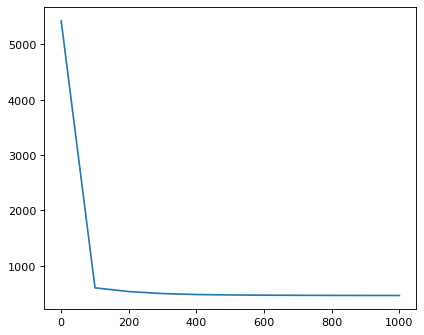

In [8]:
plot_nn_loss(losses)

In [9]:
obj1._net_A.shape, obj1._net_B.shape, obj1._w.shape #check

((3000, 3000), (3000, 3000), (6000, 6000))

In [10]:
w12 = obj1._w[:obj1._net_A.shape[0], obj1._net_A.shape[1]:]

np.mean(w12)  

1.0002169791476756

In [11]:
#selected LR pairs
candidates = obj1.get_candidates(df1)
print(len(candidates))
candidates[:5]

160


['IGF1_NTRK2', 'AREG_NTRK2', 'FGF2_NTRK2', 'FGF7_NTRK2', 'BDNF_NTRK2']

In [ ]:
# np.savetxt("./data/skin_projections_pair.csv", projections, delimiter="\t")

# projections = np.genfromtxt("./data/skin_projections_pair.csv", delimiter="\t")

In [13]:
df_nn = nn_aligned_dist(obj1, projections)
df_nn

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
XIST_LAPTM4A,"(2477, 1016)",0.000001,1,1.108373e+02
PTRF_PTPRC,"(813, 2790)",0.000006,2,1.765379e+02
DUSP1_CXCR4,"(2097, 2548)",0.000008,3,1.436162e+02
CLEC3B_XIST,"(2877, 2477)",0.000010,4,1.099613e+02
HNRNPH1_SERPINF1,"(765, 1973)",0.000010,5,1.189237e+02
...,...,...,...,...
BCL2L15_C1orf228,"(1, 1338)",0.028988,8999996,1.659775e-23
BCL2L15_F12,"(1, 740)",0.028988,8999997,1.659775e-23
BCL2L15_SHBG,"(1, 1334)",0.028988,8999998,1.659775e-23
BCL2L15_DISP1,"(1, 1354)",0.028988,8999999,1.659775e-23


In [ ]:
#df_nn_to_output = df_nn.iloc[:1000, :]
#df_nn_to_output.to_csv('distances_nn.csv')

[[ 1.         -0.16488184]
 [-0.16488184  1.        ]]


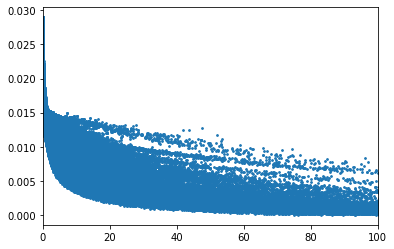

In [14]:
#check corr
select = df_nn['correspondence_score'] != 0
nX = np.asarray(df_nn['correspondence_score'][select])
nY = np.asarray(df_nn['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
# df_nn_filtered = df_nn.loc[candidates]
# len(df_nn_filtered)

In [15]:
df_nn_filtered = filtered_nn_aligned_dist(df_nn, candidates)
df_nn_filtered.head()

manifold aligned # of L-R pairs: 160


,idx,dist,rank,correspondence_score,rank_filtered
VCAM1_ITGB2,"(1458, 491)",0.000474,8712,106.982370,1
CCL2_CXCR4,"(2820, 2548)",0.000779,14430,540.281406,2
CXCL12_CXCR4,"(2919, 2548)",0.000835,15391,536.626422,3
CXCL14_CXCR4,"(2994, 2548)",0.000879,16079,862.240276,4
CCL2_CCR7,"(2820, 2138)",0.001036,18186,807.705825,5


In [16]:
df_enriched = chi2_test(df_nn, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched


Total enriched: 13 / 9000000


,idx,dist,rank,correspondence_score,q_val,rank_filtered
VCAM1_ITGB2,"(1458, 491)",0.000474,8712,106.982370,0.001814,1
CCL2_CXCR4,"(2820, 2548)",0.000779,14430,540.281406,0.004872,2
CXCL12_CXCR4,"(2919, 2548)",0.000835,15391,536.626422,0.005618,3
CXCL14_CXCR4,"(2994, 2548)",0.000879,16079,862.240276,0.006272,4
CCL2_CCR7,"(2820, 2138)",0.001036,18186,807.705825,0.009104,5
CCL19_CXCR4,"(2993, 2548)",0.001089,18757,1964.685417,0.010226,6
CXCL12_CCR7,"(2919, 2138)",0.001092,18807,802.241724,0.010299,7
CCL2_TNF,"(2820, 2815)",0.001128,19199,159.410090,0.011114,8
CXCL14_CCR7,"(2994, 2138)",0.001136,19303,1289.025469,0.011297,9
CXCL1_CCR7,"(2596, 2138)",0.001226,20261,107.058778,0.013517,10


In [ ]:
df_nn_filtered.loc['CCL19_CCR7']

#### visualization:

In [17]:
Xct.add_names_to_nets(obj1)

completed.


In [18]:
targets = vis.get_Xct_pairs(df_enriched)
targets

(['VCAM1', 'ITGB2'],
 ['CCL2', 'CXCR4'],
 ['CXCL12', 'CXCR4'],
 ['CXCL14', 'CXCR4'],
 ['CCL2', 'CCR7'],
 ['CCL19', 'CXCR4'],
 ['CXCL12', 'CCR7'],
 ['CCL2', 'TNF'],
 ['CXCL14', 'CCR7'],
 ['CXCL1', 'CCR7'],
 ['CCL19', 'CCR7'],
 ['CXCL1', 'CXCR4'],
 ['CTGF', 'ITGB2'])

In [ ]:
vis.plot_pcNet(obj1, view='sender', target=['CCL19', 'CXCL12'], top_edges=40, show = True, verbose = True)

In [ ]:
vis.plot_pcNet(obj1, view='receiver', target=['CCR7', 'CXCR4'], top_edges=40, show = True, verbose = True)

In [19]:
g1 = vis.plot_pcNet(obj1, view='sender', target=['CCL19', 'CXCL12'], top_edges=40, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', target=['CCR7', 'CXCR4'], top_edges=40, show = False, verbose = True)

identified 217 TF(s) along with 2 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 32, # of edges: 40
identified 217 TF(s) along with 2 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 31, # of edges: 40


merged graphs: 
# of nodes: 63, # of edges: 80
edge from CCL19 to CCR7 added
edge from CXCL12 to CXCR4 added


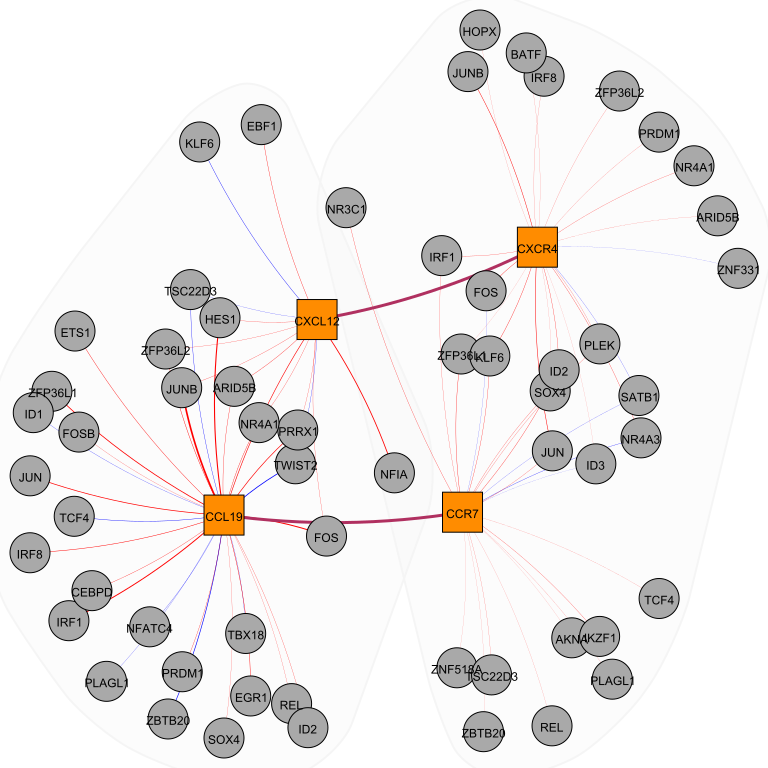

In [20]:
vis.plot_XNet(g1, g2, Xct_pair = [('CCL19', 'CCR7'), ('CXCL12', 'CXCR4')], verbose = True)

In [ ]:
g1 = vis.plot_pcNet(obj1, view='sender', target=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', target=[targets[0][1]], top_edges=20, show = False, verbose = True)
vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True)

In [ ]:
# i = 0 
# for p in candidates:
#     if df_nn.loc[p].values[2] < 200: #rank < ?
#         i += 1
#         print(p, "idx, dist, rank, score, rank%:", ' '.join(map(str, df_nn.loc[p].values)), f'{round(100* df_nn.loc[p].values[2]/len(df_nn), 5)}%')

# print('\nTotal enriched:', i)

## mode 'comb':

In [ ]:
obj2 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'comb', verbose = True)

In [ ]:
w12 = obj2._w[:obj2._net_A.shape[0], obj2._net_A.shape[1]:]

np.mean(w12)  

In [ ]:
projections2, losses2 = dNN.train_and_project(counts_np1, obj2._w, dim = 2, steps = 1000, lr = 0.001)


In [ ]:
plot_nn_loss(losses2)

In [ ]:
# np.savetxt("./data/skin_projections_comb.csv", projections2, delimiter="\t")

# projections2 = np.genfromtxt("./data/skin_projections_comb.csv", delimiter="\t")

In [ ]:
df_nn2 = nn_aligned_dist(obj2, projections2)
df_nn2.head()

In [ ]:
#check corr
select = df_nn2['correspondence_score'] != 0
nX = np.asarray(df_nn2['correspondence_score'][select])
nY = np.asarray(df_nn2['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
#df_nn_to_output2 = df_nn2.iloc[:1000, :]
#df_nn_to_output2.to_csv('distances_nn2.csv')

In [ ]:
df_enriched2 = chi2_test(df_nn2, df = 3, pval = 0.05, FDR = True, candidates = candidates)
df_enriched2

## mode pairs:

In [ ]:
obj3 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'pairs', verbose = True)

In [ ]:
w12 = obj3._w[:obj3._net_A.shape[0], obj3._net_A.shape[1]:]

np.mean(w12)  

In [ ]:
projections3, losses3 = dNN.train_and_project(counts_np1, obj3._w, dim = 2, steps = 1000, lr = 0.001)

In [ ]:
plot_nn_loss(losses3)

In [ ]:
# np.savetxt("./data/skin_projections_all.csv", projections3, delimiter="\t")

# projections3 = np.genfromtxt("./data/skin_projections_all.csv", delimiter="\t")

In [ ]:
df_nn3 = nn_aligned_dist(obj3, projections3)
df_nn3.head()

In [ ]:
#check corr
select = df_nn3['correspondence_score'] != 0
nX = np.asarray(df_nn3['correspondence_score'][select])
nY = np.asarray(df_nn3['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
#df_nn_to_output3 = df_nn3.iloc[:20000, :]
#df_nn_to_output3.to_csv('distances_nn3.csv')

In [ ]:
df_enriched3 = chi2_test(df_nn3, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched3

### Inflam.DC to Inflam. TC:

In [21]:
# obj1 = Xct(ada, 'Inflam. DC', 'Inflam. TC', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_DC2TC_LS', mode = 'full', verbose = True)

obj1 = Xct(ada, 'Inflam. DC', 'Inflam. TC', build_GRN = False,
           pcNet_name = 'net_DC2TC_LS', mode = 'full', verbose = True)
print(obj1)

init an Xct object for interactions from Inflam. DC (81) to Inflam. TC (266)...
loading GRNs...
building correspondence...
init completed.
Xct object for interactions from Inflam. DC (81) to Inflam. TC (266)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [22]:
df1 = obj1.fill_metric()
df1

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
18,IGF1,NTRK2,0.015782,0.188672,0.019926,0.382669,1.262558,2.028219,8.944272,3.278712,-0.338065,-0.067928
28,AREG,NTRK2,0.302649,0.188672,0.695448,0.382669,2.297869,2.028219,2.755452,3.278712,0.082755,-0.067928
40,EFNA1,NTRK2,0.040046,0.188672,0.071560,0.382669,1.786941,2.028219,6.679971,3.278712,-0.060825,-0.067928
56,VEGFA,NTRK2,0.264259,0.188672,0.576541,0.382669,2.181724,2.028219,2.873324,3.278712,0.190714,-0.067928
198,CD8A,LAT,0.016989,0.746377,0.023090,1.278990,1.359118,1.713596,8.944272,1.515218,-0.338065,-0.006231
...,...,...,...,...,...,...,...,...,...,...,...,...
7370,CXCL8,LPAR2,0.834715,0.057883,2.376544,0.159946,2.847133,2.763275,1.846864,6.909344,0.391188,0.082742
7703,IL32,PTGER1,1.086030,0.014364,1.565225,0.054677,1.441235,3.806483,1.151984,16.278821,0.062660,0.219659
7882,PCSK1N,GPR171,0.015782,0.582902,0.019926,1.139179,1.262558,1.954321,8.944272,1.831049,-0.338065,-0.010688
7920,CLEC2D,KLRB1,0.077279,0.373006,0.140790,1.048742,1.821834,2.811599,4.855375,2.745485,0.041242,0.323326


In [23]:
#selected LR pairs
candidates = obj1.get_candidates(df1)
print(len(candidates))
candidates[:5]

231


['IGF1_NTRK2', 'AREG_NTRK2', 'EFNA1_NTRK2', 'VEGFA_NTRK2', 'CD8A_LAT']

In [24]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 81), (3000, 266))

In [25]:
projections, losses = dNN.train_and_project(counts_np1, obj1._w, dim = 2, steps = 1000, lr = 0.001)

Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=266, out_features=92, bias=True)
  (linear2): Linear(in_features=92, out_features=23, bias=True)
  (linear3): Linear(in_features=23, out_features=2, bias=True)
)
1 6357.74755859375
100 700.3829956054688
200 543.38916015625
300 502.55035400390625
400 489.3795471191406
500 484.6355285644531
600 482.5810546875
700 481.4896240234375
800 480.8389587402344
900 480.422607421875
1000 480.13079833984375


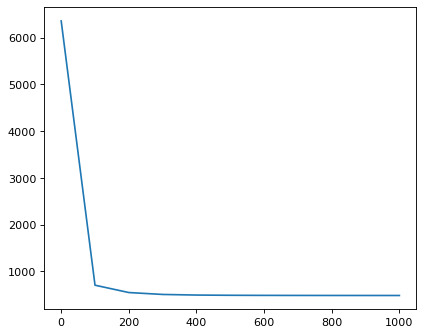

In [26]:
plot_nn_loss(losses)

In [27]:
df_nn = nn_aligned_dist(obj1, projections)
df_nn

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
KLF6_TIGIT,"(2139, 2270)",0.000004,1,1.641788e+02
IL7R_IL13,"(2723, 2869)",0.000005,2,3.492344e+02
CCL17_MT1E,"(2990, 1565)",0.000005,3,8.297805e+02
HLA-DRB6_CDC42SE1,"(2527, 823)",0.000007,4,1.275867e+02
HLA-DPA1_MBP,"(2987, 252)",0.000007,5,2.629208e+02
...,...,...,...,...
FAM89A_AMPH,"(0, 1861)",0.029157,8999996,1.734260e-23
FAM89A_LGR6,"(0, 1865)",0.029157,8999997,1.734260e-23
FAM89A_DUSP8,"(0, 1870)",0.029157,8999998,1.734260e-23
FAM89A_NNAT,"(0, 1872)",0.029157,8999999,1.734260e-23


[[ 1.         -0.14845533]
 [-0.14845533  1.        ]]


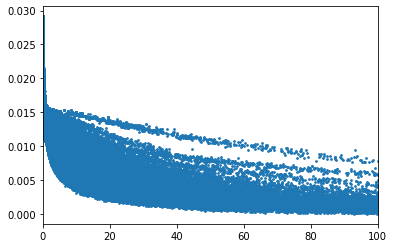

In [28]:
#check corr
select = df_nn['correspondence_score'] != 0
nX = np.asarray(df_nn['correspondence_score'][select])
nY = np.asarray(df_nn['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [29]:
df_enriched = chi2_test(df_nn, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched


Total enriched: 10 / 9000000


,idx,dist,rank,correspondence_score,q_val,rank_filtered
S100A8_CD69,"(2766, 2943)",0.000045,96,241.362395,0.000146,1
CCL17_CXCR4,"(2990, 2548)",0.000173,1189,725.900652,0.000644,2
HLA-DMA_CD74,"(2065, 2991)",0.000273,2735,260.878213,0.001108,3
S100B_TNF,"(2883, 2815)",0.000333,3727,104.641324,0.001484,4
CCL22_CXCR4,"(2937, 2548)",0.000420,5347,271.270722,0.002068,5
CXCL8_CXCR4,"(2941, 2548)",0.000564,7871,139.055943,0.003407,6
S100A8_ITGB2,"(2766, 491)",0.001138,16730,57.807664,0.013144,7
CCL17_CXCR6,"(2990, 509)",0.001700,22802,412.759866,0.032148,8
TNFRSF1B_TNF,"(703, 2815)",0.001737,23197,36.196450,0.033724,9
CCL22_CXCR6,"(2937, 509)",0.001971,25590,154.249299,0.044674,10


#### visualization:

In [30]:
Xct.add_names_to_nets(obj1)

completed.


In [31]:
targets = vis.get_Xct_pairs(df_enriched)
targets

(['S100A8', 'CD69'],
 ['CCL17', 'CXCR4'],
 ['HLA-DMA', 'CD74'],
 ['S100B', 'TNF'],
 ['CCL22', 'CXCR4'],
 ['CXCL8', 'CXCR4'],
 ['S100A8', 'ITGB2'],
 ['CCL17', 'CXCR6'],
 ['TNFRSF1B', 'TNF'],
 ['CCL22', 'CXCR6'])

identified 218 TF(s) along with 3 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 30
identified 216 TF(s) along with 3 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 31, # of edges: 30
merged graphs: 
# of nodes: 52, # of edges: 60
edge from CCL17 to CXCR4 added
edge from CCL22 to CXCR4 added
edge from CXCL8 to CXCR4 added


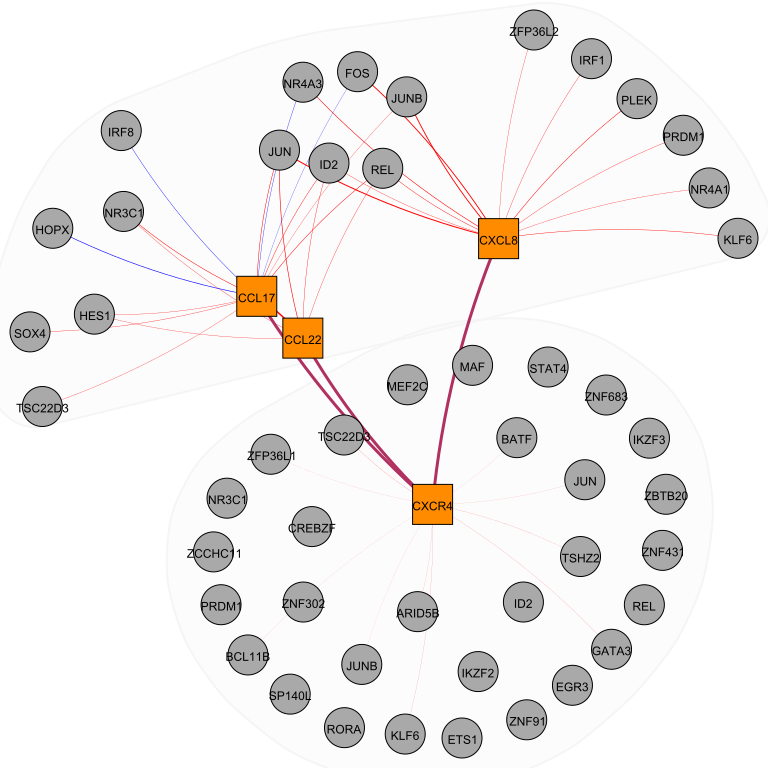

In [32]:
g1 = vis.plot_pcNet(obj1, view='sender', target=[targets[1][0], targets[4][0], targets[5][0]], top_edges=30, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', target=[targets[1][1], targets[4][1], targets[5][1]], top_edges=30, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[1], targets[4], targets[5]], verbose = True)